In [1]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup, Comment
import time
import sys
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from io import StringIO
import io
import copy

import matplotlib.pyplot as plt

In [2]:
all_coaches_data = pd.read_csv('all_coach_data.csv', encoding="utf-8-sig")

all_player_cf_tour_avg_data = pd.read_csv('all_player_cf_tour_avg_data.csv', encoding="utf-8-sig")
all_player_crs_avg_data = pd.read_csv('all_player_crs_avg_data.csv', encoding="utf-8-sig")
all_player_mm_tour_avg_data = pd.read_csv('all_player_mm_tour_avg_data.csv', encoding="utf-8-sig")

all_team_ap_poll_data = pd.read_csv('all_team_ap_poll_data.csv', encoding="utf-8-sig")

all_team_crs_advanced_data = pd.read_csv('all_team_crs_advanced_data.csv', encoding="utf-8-sig")
all_team_crs_average_data = pd.read_csv('all_team_crs_average_data.csv', encoding="utf-8-sig")
all_team_crs_misc_data = pd.read_csv('all_team_crs_misc_data.csv', encoding="utf-8-sig")

all_team_kenpom_data = pd.read_csv('all_team_kenpom_data.csv', encoding="utf-8-sig")

all_team_ncrs_advanced_data = pd.read_csv('all_team_ncrs_advanced_data.csv', encoding="utf-8-sig")
all_team_ncrs_average_data = pd.read_csv('all_team_ncrs_average_data.csv', encoding="utf-8-sig")
all_team_ncrs_misc_data = pd.read_csv('all_team_ncrs_misc_data.csv', encoding="utf-8-sig")

all_team_tournament_data = pd.read_csv('all_team_tournament_data.csv', encoding="utf-8-sig")

team_index_custom = pd.read_csv('team_index_custom.csv', encoding="utf-8-sig")
team_index_season = pd.read_csv('team_index_season.csv', encoding="utf-8-sig")


### Merging 'team_id' to all datasets from 'team_index_custom'

In [3]:
# Remove spaces before and after the values in the 'team_id' column in 'team_index_custom'
team_index_custom['team_id'] = team_index_custom['team_id'].astype(str).str.strip()

# Convert 'team_id' back to numeric if necessary
team_index_custom['team_id'] = pd.to_numeric(team_index_custom['team_id'], errors='coerce')

# Merging 'team_id' from 'team_index_custom' into 'team_index_season' based on 'Team'
team_index_season = team_index_season.merge(team_index_custom[['Team', 'team_id']], on='Team', how='left')

# Ensure 'team_id' is rounded to the nearest whole number and set its data type to Int64
team_index_season['team_id'] = np.round(team_index_season['team_id']).astype('Int64')
team_index_custom['team_id'] = np.round(team_index_custom['team_id']).astype('Int64')

# Dropping duplicates after merge based on 'season' and 'team_id'
team_index_season = team_index_season.drop_duplicates(subset=['season', 'team_id'])

# Checking for rows where 'team_id' is NaN or missing
missing_team_id_rows = team_index_season[team_index_season['team_id'].isna()]

# Displaying the rows with missing 'team_id'
missing_team_id_rows

,Team,nickname,abbrev,conference,location,home_venue,season,team_id


In [4]:
# Assuming 'team_index_custom' and 'team_index_season' are already loaded

# Remove spaces before and after the text in the 'Team' column in both DataFrames
team_index_custom['Team'] = team_index_custom['Team'].str.strip()
team_index_season['Team'] = team_index_season['Team'].str.strip()

# Ensure there are no spaces in 'team_id' column and convert it to numeric
team_index_custom['team_id'] = pd.to_numeric(team_index_custom['team_id'].astype(str).str.strip(), errors='coerce')

# List of DataFrames to clean
dataframes = {
    "all_team_ap_poll_data": all_team_ap_poll_data,
    "all_team_crs_advanced_data": all_team_crs_advanced_data,
    "all_team_crs_average_data": all_team_crs_average_data,
    "all_team_crs_misc_data": all_team_crs_misc_data,
    "all_team_kenpom_data": all_team_kenpom_data,
    "all_team_ncrs_advanced_data": all_team_ncrs_advanced_data,
    "all_team_ncrs_average_data": all_team_ncrs_average_data,
    "all_team_ncrs_misc_data": all_team_ncrs_misc_data,
    "all_team_tournament_data": all_team_tournament_data    
}

# Cleaning and processing each DataFrame
for name, df in dataframes.items():
    # Merge 'team_id' from 'team_index_custom' based on 'Team'
    df = df.merge(team_index_custom[['Team', 'team_id']], on='Team', how='left')

    # Ensure 'team_id' is rounded to the nearest whole number and set its data type
    df['team_id'] = np.round(df['team_id']).astype('Int64')

    # Drop duplicates based on 'season' and 'team_id'
    df = df.drop_duplicates(subset=['season', 'team_id'])

    # Update the DataFrame in the dictionary
    dataframes[name] = df

# Unpacking the cleaned DataFrames back to their original variables
all_team_ap_poll_data = dataframes["all_team_ap_poll_data"]
all_team_crs_advanced_data = dataframes["all_team_crs_advanced_data"]
all_team_crs_average_data = dataframes["all_team_crs_average_data"]
all_team_crs_misc_data = dataframes["all_team_crs_misc_data"]
all_team_kenpom_data = dataframes["all_team_kenpom_data"]
all_team_ncrs_advanced_data = dataframes["all_team_ncrs_advanced_data"]
all_team_ncrs_average_data = dataframes["all_team_ncrs_average_data"]
all_team_ncrs_misc_data = dataframes["all_team_ncrs_misc_data"]
all_team_tournament_data = dataframes["all_team_tournament_data"]


In [5]:


# List of DataFrames to check for NaN values in 'team_id'
dataframes_to_check = [
    all_team_ap_poll_data,
    all_team_crs_advanced_data,
    all_team_crs_average_data,
    all_team_crs_misc_data,
    all_team_kenpom_data,
    all_team_ncrs_advanced_data,
    all_team_ncrs_average_data,
    all_team_ncrs_misc_data,
    all_team_tournament_data
]

# Initialize an empty DataFrame to store rows with NaN 'team_id'
nan_team_id_rows = pd.DataFrame()

# Loop through each DataFrame and append rows with NaN 'team_id' to the new DataFrame
for df in dataframes_to_check:
    nan_team_id_rows = pd.concat([nan_team_id_rows, df[df['team_id'].isna()]])

# Display the DataFrame with all rows that have NaN in 'team_id'
nan_team_id_rows


,season,Team,AP_Pre 1,AP_Week 2,AP_Week 3,AP_Week 4,AP_Week 5,AP_Week 6,AP_Week 7,AP_Week 8,...,Win %,AdjTempo,AdjOE,AdjDE,AdjEM,bracket_region,round,champion_share,make_tournament,seed_tournament


### Combining team conference and non conference stats

In [6]:
# List of DataFrames to fill NaN or blanks with zero
dataframes_to_fill = [
    all_team_ap_poll_data,
    all_team_crs_advanced_data,
    all_team_crs_average_data,
    all_team_crs_misc_data,
    all_team_kenpom_data,
    all_team_ncrs_advanced_data,
    all_team_ncrs_average_data,
    all_team_ncrs_misc_data,
    all_team_tournament_data
]

# Fill NaN or blank values with zero for each DataFrame
for df in dataframes_to_fill:
    df.fillna(0, inplace=True)

In [7]:


# Columns to exclude from renaming
exclude_columns = ['season', '#', 'Team', 'team_id']

# Convert relevant columns to numeric in both DataFrames before renaming
for df in [all_team_crs_advanced_data, all_team_ncrs_advanced_data]:
    for col in all_team_crs_advanced_data.columns:
        if col not in exclude_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

# Rename columns in all_team_crs_advanced_data (except the excluded columns)
all_team_crs_advanced_data = all_team_crs_advanced_data.rename(
    columns={col: f'crs_{col}' for col in all_team_crs_advanced_data.columns if col not in exclude_columns}
)

# Merge the renamed all_team_crs_advanced_data into all_team_ncrs_advanced_data using 'season' and 'team_id' as criteria
merged_df = pd.merge(
    all_team_ncrs_advanced_data,
    all_team_crs_advanced_data,
    on=['season', 'team_id'],
    how='left'
)

# Ensure 'team_id' is converted to numeric (if it's not already)
merged_df['team_id'] = pd.to_numeric(merged_df['team_id'], errors='coerce')

# Dropping any duplicates based on 'season' and 'team_id'
merged_df = merged_df.drop_duplicates(subset=['season', 'team_id'])

# Fill NaN values with 0 if necessary
merged_df['team_id'].fillna(0, inplace=True)

# Convert 'team_id' to integer (round if necessary)
merged_df['team_id'] = merged_df['team_id'].astype('Int64')

# Dropping columns '#_y' and 'Team_y'
merged_df = merged_df.drop(columns=['#_y', 'Team_y'])

# Renaming the columns '#_x' and 'Team_x' to '#' and 'Team'
merged_df = merged_df.rename(columns={'#_x': '#', 'Team_x': 'Team'})

merged_df.fillna(0, inplace=True)

# List of columns to average
columns_to_average = [
    'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 
    'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 
    'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace'
]

# Convert the columns to numeric before averaging to ensure consistent format
for col in columns_to_average:
    crs_col = f'crs_{col}'
    if crs_col in merged_df.columns:  # Ensure the crs_col exists
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
        merged_df[crs_col] = pd.to_numeric(merged_df[crs_col], errors='coerce')
        merged_df[col] = (merged_df[col] + merged_df[crs_col]) / 2

# Drop the crs_ columns after averaging
merged_df = merged_df.drop(columns=[f'crs_{col}' for col in columns_to_average if f'crs_{col}' in merged_df.columns])

# Dropping any duplicates based on 'season' and 'team_id'
merged_df = merged_df.drop_duplicates(subset=['season', 'team_id'])

# Final DataFrame after merging and averaging
all_team_advanced_data = merged_df
all_team_advanced_data

,season,#,Team,TS%,eFG%,Total S%,ORB%,DRB%,TRB%,AST%,...,STL%,BLK%,PPS,FIC40,ORtg,DRtg,eDiff,Poss,Pace,team_id
0,2024,1,Iowa State,0.5695,0.5415,156.50,31.05,73.65,52.60,58.70,...,16.05,12.05,1.35,67.20,113.70,86.10,27.60,969.55,70.15,127
1,2024,2,Houston,0.5315,0.5025,147.20,39.50,73.35,55.55,50.05,...,16.60,18.10,1.20,64.20,114.25,83.10,31.20,922.75,65.40,114
2,2024,3,Brigham Young,0.5780,0.5555,155.40,32.75,80.15,56.75,63.70,...,9.05,8.35,1.30,70.75,116.55,94.75,21.80,1035.90,71.90,30
3,2024,4,Liberty,0.5805,0.5660,152.00,25.95,78.15,52.30,59.65,...,7.75,6.60,1.30,61.00,114.35,94.15,20.10,869.15,65.90,142
4,2024,5,Creighton,0.6265,0.6050,166.20,26.80,76.80,55.15,58.40,...,5.70,8.05,1.40,73.35,121.35,97.05,24.35,982.00,68.95,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7232,2003,319,Jackson State,0.5030,0.4575,140.65,25.40,63.20,43.80,51.85,...,12.80,6.60,1.15,38.80,90.20,99.60,-9.40,1031.65,75.70,129
7233,2003,320,North Carolina A&T,0.4660,0.4430,129.40,32.05,62.55,46.60,40.15,...,9.25,4.15,1.05,27.15,87.40,111.00,-23.60,900.90,68.25,201
7234,2003,321,Radford,0.4620,0.4170,136.75,28.50,63.95,45.20,42.25,...,7.45,8.25,1.05,31.60,87.95,105.45,-17.50,955.35,70.15,241
7235,2003,322,Coppin State,0.5080,0.4710,149.95,32.15,64.80,48.30,46.40,...,11.75,6.45,1.15,33.20,92.70,105.50,-12.75,817.05,58.65,60


In [8]:


# Columns to exclude from renaming
exclude_columns = ['season', '#', 'Team', 'team_id']

# Convert relevant columns to numeric in both DataFrames before renaming
for df in [all_team_crs_average_data, all_team_ncrs_average_data]:
    for col in all_team_ncrs_average_data.columns:
        if col not in exclude_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

# Rename columns in all_team_crs_average_data (except the excluded columns)
all_team_crs_average_data = all_team_crs_average_data.rename(
    columns={col: f'crs_{col}' for col in all_team_crs_average_data.columns if col not in exclude_columns}
)

# Merge the renamed all_team_crs_average_data into all_team_ncrs_average_data using 'season' and 'team_id' as criteria
merged_df = pd.merge(
    all_team_ncrs_average_data,
    all_team_crs_average_data,
    on=['season', 'team_id'],
    how='left'
)

# Ensure 'team_id' is converted to numeric (if it's not already)
merged_df['team_id'] = pd.to_numeric(merged_df['team_id'], errors='coerce')

# Dropping any duplicates based on 'season' and 'team_id'
merged_df = merged_df.drop_duplicates(subset=['season', 'team_id'])

# Fill NaN values with 0 if necessary
merged_df['team_id'].fillna(0, inplace=True)

# Convert 'team_id' to integer (round if necessary)
merged_df['team_id'] = merged_df['team_id'].astype('Int64')

# Dropping columns '#_y' and 'Team_y'
merged_df = merged_df.drop(columns=['#_y', 'Team_y'])

# Renaming the columns '#_x' and 'Team_x' to '#' and 'Team'
merged_df = merged_df.rename(columns={'#_x': '#', 'Team_x': 'Team'})

merged_df.fillna(0, inplace=True)

# List of columns to average
columns_to_average = [
    'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 
    'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 
    'BPG', 'TOV', 'PF'
]

# Convert the columns to numeric before averaging to ensure consistent format
for col in columns_to_average:
    crs_col = f'crs_{col}'
    if crs_col in merged_df.columns:  # Ensure the crs_col exists
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
        merged_df[crs_col] = pd.to_numeric(merged_df[crs_col], errors='coerce')
        merged_df[col] = (merged_df[col] + merged_df[crs_col]) / 2

# Drop the crs_ columns after averaging
merged_df = merged_df.drop(columns=[f'crs_{col}' for col in columns_to_average if f'crs_{col}' in merged_df.columns])

# Final DataFrame after merging and averaging
all_team_average_data = merged_df
all_team_average_data

,season,#,Team,GP,MPG,PPG,FGM,FGA,FG%,3PM,...,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,PF,team_id
0,2024,1,Arizona,14.5,40.85,90.75,32.50,66.00,0.4925,7.90,...,0.7235,12.90,28.55,41.45,19.55,8.65,3.25,12.15,16.65,11
1,2024,2,Iowa,14.5,40.05,86.35,31.50,65.05,0.4835,6.85,...,0.7695,8.70,25.00,33.65,18.90,8.05,4.25,9.10,16.55,126
2,2024,3,James Madison,14.0,40.70,86.50,31.15,64.80,0.4800,9.15,...,0.7160,10.05,27.25,37.30,17.45,9.55,3.05,10.80,17.65,132
3,2024,4,Alabama,14.0,40.20,91.15,30.90,64.85,0.4765,11.70,...,0.7830,11.65,25.70,37.40,16.60,7.65,4.30,11.60,19.45,4
4,2024,5,Iowa State,14.0,40.00,80.20,29.00,59.75,0.4835,6.90,...,0.7030,9.45,22.85,32.35,17.25,11.20,3.35,10.45,16.05,127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7232,2003,319,Delaware State,13.0,40.15,59.70,21.55,49.35,0.4365,6.50,...,0.6860,9.60,18.75,28.35,12.45,6.40,3.10,12.85,17.90,67
7233,2003,320,Arkansas-Pine Bluff,14.0,40.15,53.65,19.10,54.40,0.3510,4.90,...,0.6305,8.45,18.85,27.30,10.15,7.90,2.75,19.30,20.50,15
7234,2003,321,Columbia,13.0,40.00,50.10,17.10,45.60,0.3745,5.10,...,0.6720,8.65,20.90,29.60,9.90,5.25,3.40,16.30,18.20,59
7235,2003,322,Nicholls State,14.0,40.15,52.00,18.50,48.85,0.3780,5.25,...,0.6390,9.70,20.95,30.70,10.00,5.70,0.90,17.10,18.40,197


In [9]:


# Columns to exclude from renaming
exclude_columns = ['season', '#', 'Team', 'team_id']

# Convert relevant columns to numeric in both DataFrames before renaming
for df in [all_team_crs_misc_data, all_team_ncrs_misc_data]:
    for col in all_team_crs_misc_data.columns:
        if col not in exclude_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

# Rename columns in all_team_crs_misc_data (except the excluded columns)
all_team_crs_misc_data = all_team_crs_misc_data.rename(
    columns={col: f'crs_{col}' for col in all_team_crs_misc_data.columns if col not in exclude_columns}
)

# Merge the renamed all_team_crs_misc_data into all_team_ncrs_misc_data using 'season' and 'team_id' as criteria
merged_df = pd.merge(
    all_team_ncrs_misc_data,
    all_team_crs_misc_data,
    on=['season', 'team_id'],
    how='left'
)

# Ensure 'team_id' is converted to numeric (if it's not already)
merged_df['team_id'] = pd.to_numeric(merged_df['team_id'], errors='coerce')

# Dropping any duplicates based on 'season' and 'team_id'
merged_df = merged_df.drop_duplicates(subset=['season', 'team_id'])

# Fill NaN values with 0 if necessary
merged_df['team_id'].fillna(0, inplace=True)

# Convert 'team_id' to integer (round if necessary)
merged_df['team_id'] = merged_df['team_id'].astype('Int64')

# Dropping columns '#_y' and 'Team_y'
merged_df = merged_df.drop(columns=['#_y', 'Team_y'])

# Renaming the columns '#_x' and 'Team_x' to '#' and 'Team'
merged_df = merged_df.rename(columns={'#_x': '#', 'Team_x': 'Team'})

merged_df.fillna(0, inplace=True)

# List of columns to average
columns_to_misc = [
    'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 
    'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', 
    "W's", "L's", 'Win %'
]

# Convert the columns to numeric before averaging to ensure consistent format
for col in columns_to_misc:
    crs_col = f'crs_{col}'
    if crs_col in merged_df.columns:  # Ensure the crs_col exists
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
        merged_df[crs_col] = pd.to_numeric(merged_df[crs_col], errors='coerce')
        merged_df[col] = (merged_df[col] + merged_df[crs_col]) / 2

# Drop the crs_ columns after averaging
merged_df = merged_df.drop(columns=[f'crs_{col}' for col in columns_to_misc if f'crs_{col}' in merged_df.columns])

# Final DataFrame after merging and averaging
all_team_misc_data = merged_df
all_team_misc_data

,season,#,Team,Dbl Dbl,Tpl Dbl,40 Pts,20 Reb,20 Ast,5 Stl,5 Blk,...,MOV,Techs,HOB,Ast/TO,Stl/TO,FT/FGA,W's,L's,Win %,team_id
0,2024,1,UNC Asheville,7.5,0.5,0.0,0.0,0.0,0.0,1.5,...,7.45,0.0,1.5900,1.35,0.50,0.3100,9.0,5.0,0.6250,325
1,2024,2,Chicago State,5.0,0.5,0.0,0.0,0.0,1.5,0.0,...,-0.30,0.0,0.7445,0.45,0.35,0.1305,5.5,8.0,0.2035,51
2,2024,3,Morehead State,13.0,0.0,0.0,0.0,0.0,1.0,0.0,...,11.90,0.0,1.5530,1.20,0.50,0.2165,10.5,4.0,0.7070,183
3,2024,4,Appalachian State,9.5,1.0,0.0,0.0,0.0,1.0,3.0,...,12.40,0.0,1.4995,1.45,0.65,0.2140,12.0,2.5,0.8080,10
4,2024,5,New Hampshire,9.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.35,0.0,1.4600,1.05,0.65,0.2140,7.5,7.0,0.5265,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7232,2003,319,Alabama A&M,3.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.30,0.0,1.5940,0.80,0.50,0.2455,4.0,9.5,0.3330,5
7233,2003,320,Fairleigh Dickinson,2.5,0.0,0.0,0.0,0.0,1.0,0.5,...,-1.90,0.5,1.5420,0.95,0.45,0.2285,7.0,6.5,0.5280,84
7234,2003,321,Mount St. Mary's,2.0,0.0,0.0,0.0,0.0,1.0,0.5,...,-6.20,1.0,1.5455,0.75,0.55,0.2605,5.5,8.0,0.4445,185
7235,2003,322,North Carolina A&T,0.5,0.0,0.0,0.0,0.0,0.5,0.0,...,-16.35,0.0,1.4015,0.50,0.35,0.1680,0.5,12.5,0.0280,201


### Merging all combined dfs into one df

In [10]:

# Columns to merge from all_team_average_data
average_columns = [
    'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 
    'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 
    'TOV', 'PF'
]

# Columns to merge from all_team_misc_data
misc_columns = [
    'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 
    'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', 
    "W's", "L's", 'Win %'
]

# Selecting the required columns along with 'team_id' and 'season' from both DataFrames
all_team_average_data_selected = all_team_average_data[['team_id', 'season'] + average_columns]
all_team_misc_data_selected = all_team_misc_data[['team_id', 'season'] + misc_columns]

# Merging the selected columns from all_team_average_data into all_team_advanced_data
all_team_advanced_data = pd.merge(
    all_team_advanced_data,
    all_team_average_data_selected,
    on=['team_id', 'season'],
    how='left'
)

# Merging the selected columns from all_team_misc_data into all_team_advanced_data
all_team_advanced_data = pd.merge(
    all_team_advanced_data,
    all_team_misc_data_selected,
    on=['team_id', 'season'],
    how='left'
)

# Dropping duplicate rows based on 'team_id' and 'season'
all_team_advanced_data = all_team_advanced_data.drop_duplicates(subset=['team_id', 'season'])

# Filling all NaN values with 0
all_team_advanced_data = all_team_advanced_data.fillna(0)

# Final DataFrame after merging the specified columns
all_team_advanced_data

,season,#,Team,TS%,eFG%,Total S%,ORB%,DRB%,TRB%,AST%,...,High Game,MOV,Techs,HOB,Ast/TO,Stl/TO,FT/FGA,W's,L's,Win %
0,2024,1,Iowa State,0.5695,0.5415,156.50,31.05,73.65,52.60,58.70,...,94.5,20.05,0.0,1.5870,1.65,1.10,0.2530,11.5,2.5,0.8610
1,2024,2,Houston,0.5315,0.5025,147.20,39.50,73.35,55.55,50.05,...,89.0,20.55,0.0,1.5005,1.60,1.25,0.2200,12.5,1.5,0.9165
2,2024,3,Brigham Young,0.5780,0.5555,155.40,32.75,80.15,56.75,63.70,...,100.0,15.90,0.0,1.6370,2.05,0.70,0.1760,10.0,4.5,0.7325
3,2024,4,Liberty,0.5805,0.5660,152.00,25.95,78.15,52.30,59.65,...,95.5,13.00,0.0,1.5965,1.90,0.60,0.1585,7.5,5.5,0.6190
4,2024,5,Creighton,0.6265,0.6050,166.20,26.80,76.80,55.15,58.40,...,103.5,17.05,0.0,1.5840,1.80,0.45,0.1950,11.0,3.0,0.8500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7232,2003,319,Jackson State,0.5030,0.4575,140.65,25.40,63.20,43.80,51.85,...,87.0,-7.35,0.0,1.5185,0.75,0.60,0.2615,5.0,8.5,0.3055
7233,2003,320,North Carolina A&T,0.4660,0.4430,129.40,32.05,62.55,46.60,40.15,...,78.0,-16.35,0.0,1.4015,0.50,0.35,0.1680,0.5,12.5,0.0280
7234,2003,321,Radford,0.4620,0.4170,136.75,28.50,63.95,45.20,42.25,...,80.5,-12.55,2.5,1.4225,0.60,0.35,0.2300,4.0,9.5,0.2785
7235,2003,322,Coppin State,0.5080,0.4710,149.95,32.15,64.80,48.30,46.40,...,64.5,-6.95,1.0,1.4640,0.65,0.50,0.2085,5.5,8.0,0.3055


### Merging more team df's into our merged/average dataframe 'all_team_advanced_data'

In [11]:

# Select the columns to merge
tournament_columns = all_team_tournament_data[['team_id', 'season', 'bracket_region', 'round', 'champion_share', 'make_tournament', 'seed_tournament']]

# Merge the DataFrames
merged_df = pd.merge(all_team_advanced_data, tournament_columns, on=['team_id', 'season'], how='left')

# Dropping duplicate rows based on 'team_id' and 'season'
merged_df.fillna(0, inplace=True)
merged_df = merged_df.drop_duplicates(subset=['team_id', 'season'])


# Select the columns to merge
kenpom_columns = all_team_kenpom_data[['team_id', 'season', 'AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM']]

# Merge the DataFrames
merged_df = pd.merge(merged_df, kenpom_columns, on=['team_id', 'season'], how='left')

# Dropping duplicate rows based on 'team_id' and 'season'
merged_df.fillna(0, inplace=True)
merged_df = merged_df.drop_duplicates(subset=['team_id', 'season'])

# Select the columns to merge
kenpom_columns = all_team_ap_poll_data[['team_id', 'season', 'AP_Pre 1', 'AP_Week 2', 'AP_Week 3', 'AP_Week 4', 'AP_Week 5', 'AP_Week 6', 'AP_Week 7', 'AP_Week 8', 'AP_Week 9', 'AP_Week 10', 'AP_Week 11', 'AP_Week 12', 'AP_Week 13', 'AP_Week 14', 'AP_Week 15', 'AP_Week 16', 'AP_Week 17', 'AP_Week 18', 'AP_Final']]

# Merge the DataFrames
merged_df = pd.merge(merged_df, kenpom_columns, on=['team_id', 'season'], how='left')

# Dropping duplicate rows based on 'team_id' and 'season'
merged_df.fillna(0, inplace=True)
merged_df = merged_df.drop_duplicates(subset=['team_id', 'season'])

# List of columns to check
columns_to_check = ['AP_Pre 1', 'AP_Week 2', 'AP_Week 3', 'AP_Week 4', 'AP_Week 5',
                     'AP_Week 6', 'AP_Week 7', 'AP_Week 8', 'AP_Week 9', 'AP_Week 10',
                     'AP_Week 11', 'AP_Week 12', 'AP_Week 13', 'AP_Week 14', 'AP_Week 15',
                     'AP_Week 16', 'AP_Week 17', 'AP_Week 18', 'AP_Final']

# Replace values less than 1 with 26 in the specified columns using apply
merged_df[columns_to_check] = merged_df[columns_to_check].apply(lambda col: col.map(lambda x: 26 if x < 1 else x))

# Display the updated DataFrame
merged_df

,season,#,Team,TS%,eFG%,Total S%,ORB%,DRB%,TRB%,AST%,...,AP_Week 10,AP_Week 11,AP_Week 12,AP_Week 13,AP_Week 14,AP_Week 15,AP_Week 16,AP_Week 17,AP_Week 18,AP_Final
0,2024,1,Iowa State,0.5695,0.5415,156.50,31.05,73.65,52.60,58.70,...,26.0,24.0,23.0,12.0,14.0,10.0,6.0,8.0,6.0,26.0
1,2024,2,Houston,0.5315,0.5025,147.20,39.50,73.35,55.55,50.05,...,2.0,5.0,4.0,4.0,5.0,3.0,2.0,1.0,1.0,26.0
2,2024,3,Brigham Young,0.5780,0.5555,155.40,32.75,80.15,56.75,63.70,...,18.0,20.0,21.0,22.0,21.0,19.0,25.0,26.0,20.0,26.0
3,2024,4,Liberty,0.5805,0.5660,152.00,25.95,78.15,52.30,59.65,...,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0
4,2024,5,Creighton,0.6265,0.6050,166.20,26.80,76.80,55.15,58.40,...,22.0,18.0,17.0,13.0,19.0,17.0,15.0,12.0,10.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7232,2003,319,Jackson State,0.5030,0.4575,140.65,25.40,63.20,43.80,51.85,...,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0
7233,2003,320,North Carolina A&T,0.4660,0.4430,129.40,32.05,62.55,46.60,40.15,...,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0
7234,2003,321,Radford,0.4620,0.4170,136.75,28.50,63.95,45.20,42.25,...,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0
7235,2003,322,Coppin State,0.5080,0.4710,149.95,32.15,64.80,48.30,46.40,...,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0


### adding custom features to team data file

In [12]:
# Convert the 'round' column to string
merged_df['round'] = merged_df['round'].astype(str)

# Create the new column 'champion' based on the condition
merged_df['champion'] = merged_df['champion_share'].apply(lambda x: 1 if x == 1 else 0)

# Create new columns based on the presence of specific text in the 'round' column
merged_df['Finals'] = merged_df['round'].apply(lambda x: 1 if 'Finals' in x else 0)
merged_df['Final Four'] = merged_df['round'].apply(lambda x: 1 if 'Final Four' in x else 0)
merged_df['Elite Eight'] = merged_df['round'].apply(lambda x: 1 if 'Elite Eight' in x else 0)

In [13]:

# Sort the DataFrame
merged_df = merged_df.sort_values(by=['champion_share', 'season'], ascending=[False, False])

# List of columns to create cumulative sums for
columns_to_cumsum = [
    ('champion_share', 'sum_school_champion_shares'),
    ('champion', 'sum_school_champions'),
    ('Finals', 'sum_school_finals'),
    ('Final Four', 'sum_school_final_fours'),
    ('Elite Eight', 'sum_school_elite_eights')
]

# Sort the DataFrame by 'Player' and 'season' in ascending order
merged_df = merged_df.sort_values(by=['team_id', 'season'])

# Calculate the cumulative sums and shift by one position
for col, new_col in columns_to_cumsum:
    merged_df[new_col] = merged_df.groupby('team_id')[col].cumsum().shift(1).fillna(0)

# Adjust for every player's first season in the league
for col, new_col in columns_to_cumsum:
    # Find the first season for each player
    first_season_players = merged_df.groupby('team_id').head(1)
    
    # Set the cumulative sum to 0 for the first season
    merged_df.loc[first_season_players.index, new_col] = 0

# Sort the DataFrame back by 'season' in descending order
merged_df = merged_df.sort_values(by='season', ascending=False)

# Function to calculate the rolling sum for the last N seasons excluding the current season
def calculate_rolling_sum(df, column, new_column, window):
    rolling_sums = df.groupby('team_id')[column].apply(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    df[new_column] = rolling_sums.reset_index(level=0, drop=True)
    df[new_column] = df[new_column].fillna(0)
    return df

# Sort the DataFrame by 'Player' and 'season' in ascending order
merged_df = merged_df.sort_values(by=['team_id', 'season'])

# Calculate the rolling sums
merged_df = calculate_rolling_sum(merged_df, 'champion_share', 'sum_school_L1S_cs', 1)
merged_df = calculate_rolling_sum(merged_df, 'champion_share', 'sum_school_L3S_cs', 3)
merged_df = calculate_rolling_sum(merged_df, 'champion_share', 'sum_school_L5S_cs', 5)
merged_df = calculate_rolling_sum(merged_df, 'champion_share', 'sum_school_L8S_cs', 8)

# Sort the DataFrame back by 'season' in descending order
merged_df = merged_df.sort_values(by='season', ascending=False).fillna(0)
merged_df['champion'] = merged_df['champion'].fillna(0)

merged_df = merged_df.drop(columns=['Finals', 'Final Four', 'Elite Eight'])

# List of columns to average
ap_poll_columns = [
    'AP_Pre 1', 'AP_Week 2', 'AP_Week 3', 'AP_Week 4', 'AP_Week 5', 
    'AP_Week 6', 'AP_Week 7', 'AP_Week 8', 'AP_Week 9', 'AP_Week 10', 
    'AP_Week 11', 'AP_Week 12', 'AP_Week 13', 'AP_Week 14', 'AP_Week 15', 
    'AP_Week 16', 'AP_Week 17', 'AP_Week 18'
]

# Calculate the average of the specified columns and create the new column
merged_df['avg_ap_poll_rank_Pre_18'] = merged_df[ap_poll_columns].mean(axis=1)

ap_poll_columns = [
    'AP_Pre 1', 'AP_Week 2', 'AP_Week 3', 'AP_Week 4', 'AP_Week 5',
    'AP_Week 6', 'AP_Week 7', 'AP_Week 8', 'AP_Week 9', 'AP_Week 10',
    'AP_Week 11', 'AP_Week 12', 'AP_Week 13', 'AP_Week 14', 'AP_Week 15',
    'AP_Week 16', 'AP_Week 17', 'AP_Week 18'
]

# Create the new column 'make_all_ap_polls'
merged_df['make_all_ap_polls'] = merged_df[ap_poll_columns].apply(
    lambda row: 1 if all(value <= 25 for value in row) else 0,
    axis=1
)

merged_df = merged_df.drop(columns=['AP_Final'])

# Create the new column 'top_12_AP_Week 6'
merged_df['top_12_AP_Week 6'] = merged_df['AP_Week 6'].apply(lambda x: 1 if x <= 12 else 0)

merged_df

,season,#,Team,TS%,eFG%,Total S%,ORB%,DRB%,TRB%,AST%,...,sum_school_finals,sum_school_final_fours,sum_school_elite_eights,sum_school_L1S_cs,sum_school_L3S_cs,sum_school_L5S_cs,sum_school_L8S_cs,avg_ap_poll_rank_Pre_18,make_all_ap_polls,top_12_AP_Week 6
272,2024,273,Le Moyne,0.5440,0.5200,151.20,21.45,70.00,45.95,61.10,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,26.000000,0,0
342,2024,343,Bucknell,0.5370,0.5090,149.40,23.80,72.55,48.60,53.10,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,26.000000,0,0
157,2024,158,Oregon State,0.5445,0.5010,152.20,25.45,72.25,49.95,46.25,...,0.0,0.0,1.0,0.0,0.500000,0.500000,0.5,26.000000,0,0
199,2024,200,Bryant,0.5450,0.5220,145.45,20.60,72.70,47.65,52.30,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,26.000000,0,0
117,2024,118,Oregon,0.5470,0.5160,149.60,26.80,77.15,51.80,49.90,...,0.0,1.0,2.0,0.0,0.333333,0.666667,2.0,26.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7219,2003,306,Chicago State,0.5105,0.4790,139.30,35.10,65.55,49.90,51.25,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,26.000000,0,0
6963,2003,50,Louisville,0.5780,0.5375,154.30,35.90,66.85,51.85,59.95,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,17.444444,0,0
7005,2003,92,Central Michigan,0.6035,0.5595,162.55,37.10,68.95,54.20,59.30,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,26.000000,0,0
7229,2003,316,Columbia,0.4755,0.4300,134.85,28.45,68.05,48.35,57.85,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,26.000000,0,0


In [14]:
print(list(merged_df))

['season', '#', 'Team', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'team_id', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', "W's", "L's", 'Win %', 'bracket_region', 'round', 'champion_share', 'make_tournament', 'seed_tournament', 'AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'AP_Pre 1', 'AP_Week 2', 'AP_Week 3', 'AP_Week 4', 'AP_Week 5', 'AP_Week 6', 'AP_Week 7', 'AP_Week 8', 'AP_Week 9', 'AP_Week 10', 'AP_Week 11', 'AP_Week 12', 'AP_Week 13', 'AP_Week 14', 'AP_Week 15', 'AP_Week 16', 'AP_Week 17', 'AP_Week 18', 'champion', 'sum_school_champion_shares', 'sum_school_champions', 'sum_school_finals', 'sum_school_final_fours', 'sum_school_elite_eights', 'sum_school_L1S_cs', 'su

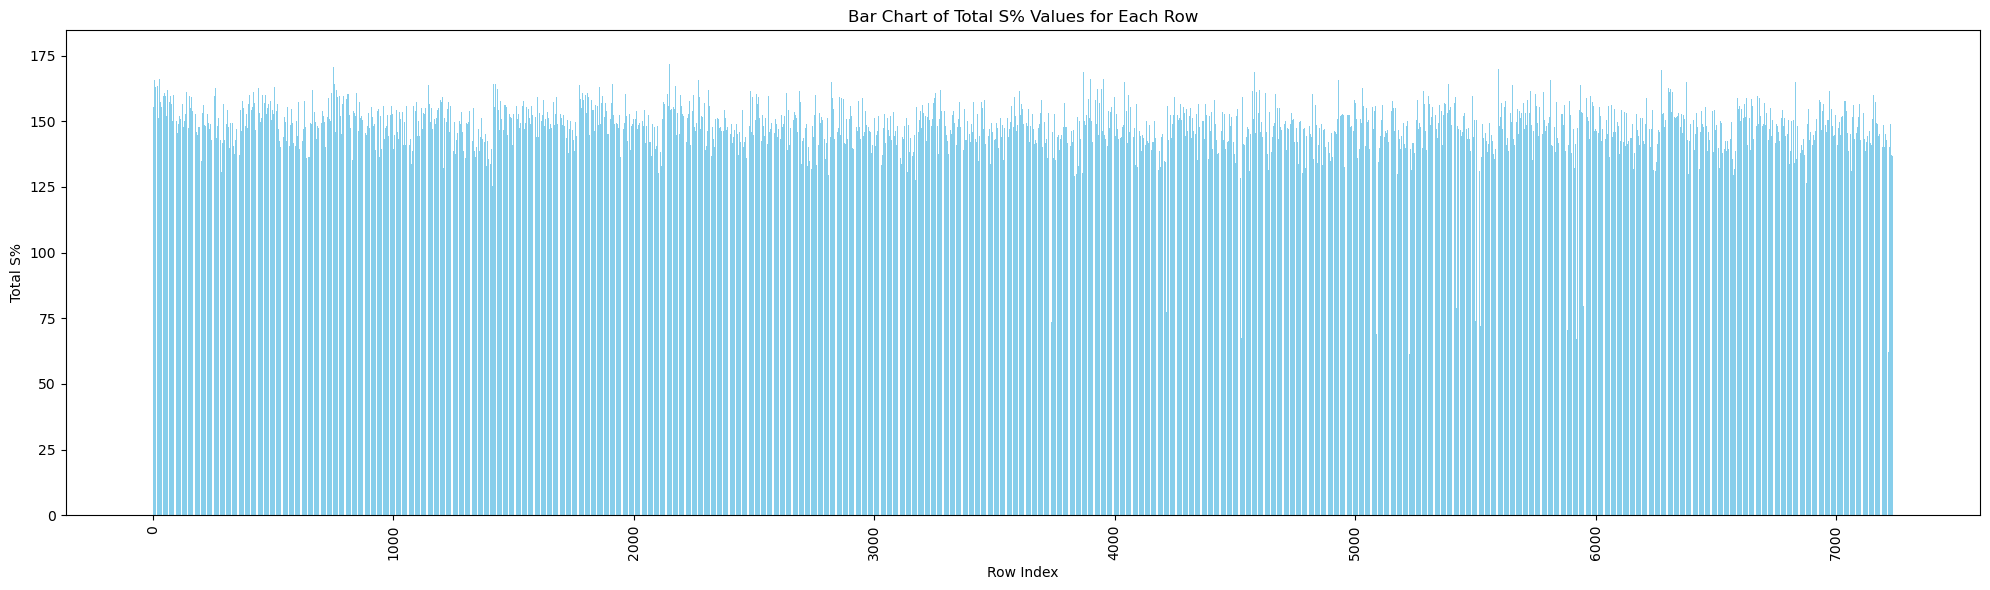

In [15]:
total_s_percentage = merged_df['Total S%']

plt.figure(figsize=(20, 6))  
plt.bar(merged_df.index, total_s_percentage, color='skyblue')
plt.xlabel('Row Index')
plt.ylabel('Total S%')
plt.title('Bar Chart of Total S% Values for Each Row')
plt.xticks(rotation=90)  
plt.tight_layout()

plt.show()

### Player Database

In [16]:
# Get the number of rows for each DataFrame
num_rows_cf_tour_avg = all_player_cf_tour_avg_data.shape[0]
num_rows_crs_tour_avg = all_player_crs_avg_data.shape[0]
num_rows_mm_tour_avg = all_player_mm_tour_avg_data.shape[0]

# Print the number of rows
print(f"Number of rows in all_player_cf_tour_avg_data: {num_rows_cf_tour_avg}")
print(f"Number of rows in all_player_crs_avg_data: {num_rows_crs_tour_avg}")
print(f"Number of rows in all_player_mm_tour_avg_data: {num_rows_mm_tour_avg}")

Number of rows in all_player_cf_tour_avg_data: 42232
Number of rows in all_player_crs_avg_data: 47860
Number of rows in all_player_mm_tour_avg_data: 15847


In [17]:
# List of columns to modify
columns_to_modify = ['GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF']

# Create a mapping of old column names to new column names with prefix
new_column_names = {col: f'cf_tour_{col}' for col in columns_to_modify}

# Rename the columns in the DataFrame
all_player_cf_tour_avg_data.rename(columns=new_column_names, inplace=True)

# List of columns to modify (you can adjust this list based on the actual columns in your DataFrame)
columns_to_modify = ['GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF']

# Create a mapping of old column names to new column names with prefix
new_column_names = {col: f'crs_{col}' for col in columns_to_modify}

# Rename the columns in the DataFrame
all_player_crs_avg_data.rename(columns=new_column_names, inplace=True)

# List of columns to modify (adjust based on the actual columns in your DataFrame)
columns_to_modify = ['GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF']

# Create a mapping of old column names to new column names with prefix
new_column_names = {col: f'mm_tour_{col}' for col in columns_to_modify}

# Rename the columns in the DataFrame
all_player_mm_tour_avg_data.rename(columns=new_column_names, inplace=True)

In [18]:
cf_tour_columns = all_player_cf_tour_avg_data[['Player', 'season', 'cf_tour_GP', 'cf_tour_MPG', 'cf_tour_PPG', 'cf_tour_FGM', 'cf_tour_FGA', 'cf_tour_FG%', 'cf_tour_3PM', 'cf_tour_3PA', 'cf_tour_3P%', 'cf_tour_FTM', 'cf_tour_FTA', 'cf_tour_FT%', 'cf_tour_ORB', 'cf_tour_DRB', 'cf_tour_RPG', 'cf_tour_APG', 'cf_tour_SPG', 'cf_tour_BPG', 'cf_tour_TOV', 'cf_tour_PF']]
all_player_data = pd.merge(all_player_crs_avg_data, cf_tour_columns, on=['Player', 'season'], how='left')
all_player_data.fillna(0, inplace=True)
all_player_data = all_player_data.drop_duplicates(subset=['Player', 'season'])

mm_tour_columns = all_player_mm_tour_avg_data[['Player', 'season', 'mm_tour_GP', 'mm_tour_MPG', 'mm_tour_PPG', 'mm_tour_FGM', 'mm_tour_FGA', 'mm_tour_FG%', 'mm_tour_3PM', 'mm_tour_3PA', 'mm_tour_3P%', 'mm_tour_FTM', 'mm_tour_FTA', 'mm_tour_FT%', 'mm_tour_ORB', 'mm_tour_DRB', 'mm_tour_RPG', 'mm_tour_APG', 'mm_tour_SPG', 'mm_tour_BPG', 'mm_tour_TOV', 'mm_tour_PF']]
all_player_data = pd.merge(all_player_data, mm_tour_columns, on=['Player', 'season'], how='left')
all_player_data.fillna(0, inplace=True)
all_player_data = all_player_data.drop_duplicates(subset=['Player', 'season'])

team_index_custom_columns = team_index_custom[['abrev', 'team_id']]
all_player_data.rename(columns={'Team': 'abrev'}, inplace=True)  # Rename 'Team' to 'abrev'
all_player_data = pd.merge(all_player_data, team_index_custom_columns, on=['abrev'], how='left')

all_player_data.fillna(0, inplace=True)
all_player_data = all_player_data.drop_duplicates(subset=['Player', 'season'])
all_player_data['team_id'] = all_player_data['team_id'].round().astype(int)
all_player_data.rename(columns={'abrev': 'team_abrev'}, inplace=True)  # Rename 'Team' to 'abrev'

all_player_data

,#,Player,team_abrev,crs_GP,crs_MPG,crs_PPG,crs_FGM,crs_FGA,crs_FG%,crs_3PM,...,mm_tour_FT%,mm_tour_ORB,mm_tour_DRB,mm_tour_RPG,mm_tour_APG,mm_tour_SPG,mm_tour_BPG,mm_tour_TOV,mm_tour_PF,team_id
0,1,Dalton Knecht,TENN,18,31.3,25.5,8.7,17.9,0.484,3.1,...,0.833,1.3,5.3,6.5,2.0,0.8,0.3,2.0,1.0,293
1,2,Zach Edey,PURD,20,32.8,25.4,8.7,14.0,0.624,0.1,...,0.682,4.7,9.8,14.5,1.8,0.5,1.8,2.7,2.0,238
2,3,Tommy Bruner,DEN,16,34.0,24.1,8.1,18.0,0.451,2.2,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68
3,4,Tucker DeVries,DRAKE,20,36.1,23.5,7.8,17.0,0.457,2.7,...,0.500,0.0,3.0,3.0,6.0,0.0,0.0,1.0,2.0,71
4,5,P.J. Haggerty,TULSA,18,35.2,23.4,7.4,14.5,0.513,0.8,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68086,2113,Jose Winston,UWM,16,15.1,1.1,0.3,1.0,0.250,0.1,...,0.000,3.0,2.0,5.0,3.0,1.0,0.0,0.0,5.0,174
68087,2114,Andre Anderson,UVM,13,10.8,0.9,0.3,1.0,0.308,0.3,...,0.000,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,339
68088,2115,Ryan Pederson,MONT,12,13.6,0.9,0.3,1.1,0.231,0.1,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,181
68089,2116,Matt Land,COM,13,10.2,0.8,0.4,1.4,0.278,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59


In [19]:
# Filter rows where 'team_id' is 0
team_id_zero_df = all_player_data[all_player_data['team_id'] == 0]

# Print the filtered DataFrame
team_id_zero_df

,#,Player,team_abrev,crs_GP,crs_MPG,crs_PPG,crs_FGM,crs_FGA,crs_FG%,crs_3PM,...,mm_tour_FT%,mm_tour_ORB,mm_tour_DRB,mm_tour_RPG,mm_tour_APG,mm_tour_SPG,mm_tour_BPG,mm_tour_TOV,mm_tour_PF,team_id
13075,1737,Ty Harper,0,17,20.3,6.3,2.2,5.3,0.422,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
16210,1610,K.J. Davis,0,18,28.1,7.1,2.6,8.1,0.315,1.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
41998,1126,Kenny Mitchell,0,18,22.8,8.6,3.2,6.9,0.460,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Creating unique player features

In [20]:
merged_df_columns = merged_df[['team_id', 'season', 'champion_share', 'champion', 'avg_ap_poll_rank_Pre_18', 'MOV']]
all_player_data = pd.merge(all_player_data, merged_df_columns, on=['team_id', 'season'], how='left')
all_player_data.fillna(0, inplace=True)
all_player_data = all_player_data.drop_duplicates(subset=['Player', 'season'])

In [21]:
# Sort the DataFrame
all_player_data = all_player_data.sort_values(by=['champion_share', 'season'], ascending=[False, False])

# List of columns to create cumulative sums for
columns_to_cumsum = [
    ('champion_share', 'sum_player_champion_shares'),
    ('champion', 'sum_player_champions'),
    ('mm_tour_GP', 'sum_mm_tour_games'),
    ('cf_tour_GP', 'sum_cf_tour_games'),
    ('crs_GP', 'sum_crs_games'),
]

# Sort the DataFrame by 'Player' and 'season' in ascending order
all_player_data = all_player_data.sort_values(by=['Player', 'season'])

# Calculate the cumulative sums and shift by one position
for col, new_col in columns_to_cumsum:
    all_player_data[new_col] = all_player_data.groupby('Player')[col].cumsum().shift(1).fillna(0)

# Adjust for every player's first season in the league
for col, new_col in columns_to_cumsum:
    # Find the first season for each player
    first_season_players = all_player_data.groupby('Player').head(1)
    
    # Set the cumulative sum to 0 for the first season
    all_player_data.loc[first_season_players.index, new_col] = 0

# Sort the DataFrame back by 'season' in descending order
all_player_data = all_player_data.sort_values(by='season', ascending=False)

# Function to calculate the rolling sum for the last N seasons excluding the current season
def calculate_rolling_sum(df, column, new_column, window):
    rolling_sums = df.groupby('Player')[column].apply(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    df[new_column] = rolling_sums.reset_index(level=0, drop=True)
    df[new_column] = df[new_column].fillna(0)
    return df

# Sort the DataFrame by 'crs_PPG' and 'season'
all_player_data = all_player_data.sort_values(by=['season', 'crs_PPG'], ascending=[False, False])

#===========================

# Sort the DataFrame by 'Player' and 'season' in ascending order
all_player_data = all_player_data.sort_values(by=['Player', 'season'])

# Calculate the cumulative sums and shift by one position
for col, new_col in columns_to_cumsum:
    all_player_data[new_col] = all_player_data.groupby('Player')[col].cumsum().shift(1).fillna(0)

# Adjust for every player's first season in the league
for col, new_col in columns_to_cumsum:
    # Find the first season for each player
    first_season_players = all_player_data.groupby('Player').head(1)
    
    # Set the cumulative sum to 0 for the first season
    all_player_data.loc[first_season_players.index, new_col] = 0

# Sort the DataFrame back by 'season' in descending order
all_player_data = all_player_data.sort_values(by='season', ascending=False)

# Function to calculate the rolling sum for the last N seasons excluding the current season
def calculate_rolling_sum(df, column, new_column, window):
    rolling_sums = df.groupby('Player')[column].apply(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    df[new_column] = rolling_sums.reset_index(level=0, drop=True)
    df[new_column] = df[new_column].fillna(0)
    return df

# Sort the DataFrame by 'Player' and 'season' in ascending order
all_player_data = all_player_data.sort_values(by=['Player', 'season'])

# Calculate the rolling sums
all_player_data = calculate_rolling_sum(all_player_data, 'champion_share', 'sum_player_L1S_cs', 1)
all_player_data = calculate_rolling_sum(all_player_data, 'champion_share', 'sum_player_L3S_cs', 3)
all_player_data = calculate_rolling_sum(all_player_data, 'champion_share', 'sum_player_L5S_cs', 5)
all_player_data = calculate_rolling_sum(all_player_data, 'champion_share', 'sum_player_L8S_cs', 8)

# Sort the DataFrame back by 'season' in descending order
all_player_data = all_player_data.sort_values(by='season', ascending=False).fillna(0)
all_player_data['champion'] = all_player_data['champion'].fillna(0)


In [22]:
# Calculate the new column 'crs_GmSc'
all_player_data['crs_GmSc'] = (
    all_player_data['crs_PPG'] +
    0.4 * all_player_data['crs_FGM'] -
    0.7 * all_player_data['crs_FGA'] -
    0.4 * (all_player_data['crs_FTA'] - all_player_data['crs_FTM']) +
    0.7 * all_player_data['crs_ORB'] +
    0.3 * all_player_data['crs_DRB'] +
    all_player_data['crs_SPG'] +
    0.7 * all_player_data['crs_APG'] +
    0.7 * all_player_data['crs_BPG'] -
    0.4 * all_player_data['crs_PF'] -
    all_player_data['crs_TOV']
)

# Calculate the new column 'crs_GmSc' for mmm tour
all_player_data['mm_tour_GmSc'] = (
    all_player_data['mm_tour_PPG'] +
    0.4 * all_player_data['mm_tour_FGM'] -
    0.7 * all_player_data['mm_tour_FGA'] -
    0.4 * (all_player_data['mm_tour_FTA'] - all_player_data['mm_tour_FTM']) +
    0.7 * all_player_data['mm_tour_ORB'] +
    0.3 * all_player_data['mm_tour_DRB'] +
    all_player_data['mm_tour_SPG'] +
    0.7 * all_player_data['mm_tour_APG'] +
    0.7 * all_player_data['mm_tour_BPG'] -
    0.4 * all_player_data['mm_tour_PF'] -
    all_player_data['mm_tour_TOV']
)


# Create the new column 'player_rating_custom'
all_player_data['player_rating_custom'] = (all_player_data['crs_GmSc'] * 2.5) + all_player_data['MOV'] - (all_player_data['avg_ap_poll_rank_Pre_18'] * .75)

### Team Database

In [23]:


# Step 1: Calculate team_rating_custom by averaging player_rating_custom based on 'season' and 'team_id'
team_rating_custom = all_player_data.groupby(['season', 'team_id'])['player_rating_custom'].mean().reset_index()
team_rating_custom.rename(columns={'player_rating_custom': 'team_rating_custom'}, inplace=True)

# Merge this back into 'merged_df'
merged_df = merged_df.merge(team_rating_custom, on=['season', 'team_id'], how='left')

# Step 2: Calculate max_player_rating_custom by finding the highest player_rating_custom for each 'season' and 'team_id'
max_player_rating_custom = all_player_data.groupby(['season', 'team_id'])['player_rating_custom'].max().reset_index()
max_player_rating_custom.rename(columns={'player_rating_custom': 'max_player_rating_custom'}, inplace=True)

# Merge this back into 'merged_df'
merged_df = merged_df.merge(max_player_rating_custom, on=['season', 'team_id'], how='left')

# Step 3: Find the player with the highest player_rating_custom for each 'season' and 'team_id'
# Create a dictionary for lookup
player_lookup = all_player_data.set_index(['season', 'team_id', 'player_rating_custom'])['Player'].to_dict()

# Create max_player column using the lookup dictionary
def get_max_player(row):
    return player_lookup.get((row['season'], row['team_id'], row['max_player_rating_custom']), None)

merged_df['max_player'] = merged_df.apply(get_max_player, axis=1)

# Sort the DataFrame by 'champion_share' (largest to smallest) and then by 'season' (largest to smallest)
merged_df = merged_df.sort_values(by=['season', 'champion_share'], ascending=[False, False])

# Display the sorted DataFrame
merged_df

,season,#,Team,TS%,eFG%,Total S%,ORB%,DRB%,TRB%,AST%,...,sum_school_L1S_cs,sum_school_L3S_cs,sum_school_L5S_cs,sum_school_L8S_cs,avg_ap_poll_rank_Pre_18,make_all_ap_polls,top_12_AP_Week 6,team_rating_custom,max_player_rating_custom,max_player
287,2024,8,UConn,0.6030,0.5780,159.00,36.40,76.70,58.15,60.95,...,1.000000,1.000000,1.000000,1.166667,3.277778,1,1,41.466667,50.141667,Cam Spencer
24,2024,7,Purdue,0.6115,0.5800,165.70,36.00,77.45,58.75,66.40,...,0.000000,0.333333,1.166667,1.500000,2.055556,1,1,43.658333,76.358333,Zach Edey
49,2024,84,NC State,0.5385,0.5095,148.95,29.55,71.30,49.90,47.20,...,0.000000,0.000000,0.000000,0.333333,26.000000,0,0,2.940625,15.950000,D.J. Horne
312,2024,20,Alabama,0.6030,0.5665,163.55,34.30,71.40,53.40,53.75,...,0.333333,0.666667,0.833333,0.833333,21.777778,0,0,18.970238,40.816667,Mark Sears
101,2024,30,Tennessee,0.5700,0.5330,157.15,33.15,72.60,53.60,62.55,...,0.333333,0.500000,1.000000,1.000000,7.166667,1,1,31.817857,53.525000,Dalton Knecht
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7230,2003,108,Southeastern Louisiana,0.4995,0.4635,137.20,32.40,72.00,50.20,55.55,...,0.000000,0.000000,0.000000,0.000000,26.000000,0,0,-1.392857,6.625000,Amir Abdur-Rahim
7231,2003,116,NC State,0.5770,0.5280,156.30,31.45,68.60,50.10,60.05,...,0.000000,0.000000,0.000000,0.000000,26.000000,0,0,5.950000,17.525000,Julius Hodge
7232,2003,306,Chicago State,0.5105,0.4790,139.30,35.10,65.55,49.90,51.25,...,0.000000,0.000000,0.000000,0.000000,26.000000,0,0,-20.035714,-16.150000,Craig Franklin
7235,2003,316,Columbia,0.4755,0.4300,134.85,28.45,68.05,48.35,57.85,...,0.000000,0.000000,0.000000,0.000000,26.000000,0,0,-27.091667,-17.350000,Marco McCottry


In [24]:
# List of columns to sum in merged_df
columns_to_sum = ['sum_player_champion_shares', 'sum_player_champions', 'sum_mm_tour_games', 'sum_cf_tour_games', 'sum_crs_games', 'sum_player_L1S_cs', 'sum_player_L3S_cs', 'sum_player_L5S_cs', 'sum_player_L8S_cs']

# Group by 'team_id' and 'season' and sum the specified columns
player_data_summed = all_player_data.groupby(['team_id', 'season'])[columns_to_sum].sum().reset_index()

# Merge the summed columns into merged_df
merged_df = merged_df.merge(
    player_data_summed,
    on=['team_id', 'season'],
    how='left'
)

merged_df = merged_df.drop_duplicates(subset=['team_id', 'season'])

# Perform the merge operation to include 'conference' from team_index_season
merged_df = merged_df.merge(team_index_season[['season', 'team_id', 'conference']], 
                            on=['season', 'team_id'], 
                            how='left')

merged_df = merged_df.drop_duplicates(subset=['team_id', 'season'])
merged_df = merged_df.fillna(0)


average_br_rating = merged_df.groupby(['bracket_region', 'season'])['team_rating_custom'].mean().reset_index()
average_br_rating = average_br_rating.rename(columns={'team_rating_custom': 'bracket_region_rating'})
merged_df = merged_df.merge(average_br_rating, on=['bracket_region', 'season'], how='left')

average_cf_rating = merged_df.groupby(['conference', 'season'])['team_rating_custom'].mean().reset_index()
average_cf_rating = average_cf_rating.rename(columns={'team_rating_custom': 'conference_rating'})
merged_df = merged_df.merge(average_cf_rating, on=['conference', 'season'], how='left')

merged_df = merged_df.drop_duplicates(subset=['team_id', 'season'])
merged_df = merged_df.fillna(0)

# Drop the 'make_tournament' column from merged_df
merged_df = merged_df.drop(columns=['make_tournament'])

# Perform a VLOOKUP-like operation using merge
merged_df['make_tournament'] = merged_df.apply(
    lambda row: all_team_tournament_data.loc[
        (all_team_tournament_data['team_id'] == row['team_id']) &
        (all_team_tournament_data['season'] == row['season']),
        'make_tournament'
    ].values[0] if not all_team_tournament_data.loc[
        (all_team_tournament_data['team_id'] == row['team_id']) &
        (all_team_tournament_data['season'] == row['season'])
    ].empty else 0,
    axis=1
)

# Drop duplicates based on 'team_id' and 'season'
merged_df = merged_df.drop_duplicates(subset=['team_id', 'season'])

# Fill any remaining missing values with 0
merged_df = merged_df.fillna(0)
merged_df = merged_df.drop_duplicates(subset=['team_id', 'season'])

In [25]:
# Filtering rows where 'make_tournament' == True
all_team_tournament_data = all_team_tournament_data[all_team_tournament_data['make_tournament'] == True]

# Selecting columns to merge, excluding the specified columns
columns_to_merge = [
    '#', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 
    'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 
    'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 
    'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF', 
    'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 
    'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', "W's", 
    "L's", 'Win %', 'AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'AP_Pre 1', 
    'AP_Week 2', 'AP_Week 3', 'AP_Week 4', 'AP_Week 5', 'AP_Week 6', 
    'AP_Week 7', 'AP_Week 8', 'AP_Week 9', 'AP_Week 10', 'AP_Week 11', 
    'AP_Week 12', 'AP_Week 13', 'AP_Week 14', 'AP_Week 15', 'AP_Week 16', 
    'AP_Week 17', 'AP_Week 18', 'champion', 'sum_school_champion_shares', 
    'sum_school_champions', 'sum_school_finals', 'sum_school_final_fours', 
    'sum_school_elite_eights', 'sum_school_L1S_cs', 'sum_school_L3S_cs', 
    'sum_school_L5S_cs', 'sum_school_L8S_cs', 'avg_ap_poll_rank_Pre_18', 
    'make_all_ap_polls', 'top_12_AP_Week 6', 'team_rating_custom', 
    'max_player_rating_custom', 'max_player', 'sum_player_champion_shares', 
    'sum_player_champions', 'sum_mm_tour_games', 'sum_cf_tour_games', 
    'sum_crs_games', 'sum_player_L1S_cs', 'sum_player_L3S_cs', 
    'sum_player_L5S_cs', 'sum_player_L8S_cs', 'conference', 
    'bracket_region_rating', 'conference_rating'
]

# Performing the merge
all_team_tournament_data = all_team_tournament_data.merge(
    merged_df[['team_id', 'season'] + columns_to_merge], 
    on=['team_id', 'season'], 
    how='left'
)

# Drop duplicates based on 'team_id' and 'season'
all_team_tournament_data = all_team_tournament_data.drop_duplicates(subset=['team_id', 'season'])

# Fill any remaining missing values with 0
all_team_tournament_data = all_team_tournament_data.fillna(0)

# Dropping the column '#'
all_team_tournament_data = all_team_tournament_data.drop(columns=['#'])

#create a column to display current mmt gp in team df - using it for coaches

# Define the function to calculate 'current_mmt_tour_games'
def calculate_tour_games(row):
    if row['champion_share'] > 0.8:
        return 6
    elif 0.55 < row['champion_share'] <= 0.8:
        return 5
    elif 0.34 < row['champion_share'] <= 0.64:
        return 4
    elif 0 < row['champion_share'] <= 0.32:
        return 2
    elif row['champion_share'] == 0 and row['make_tournament'] == True:
        return 1
    else:
        return None

# Apply the function to create the new column
all_team_tournament_data['current_mmt_tour_games'] = all_team_tournament_data.apply(calculate_tour_games, axis=1)

### Data checks

In [26]:
# Ensure 'season' is treated as numeric or int if it's not already, using .loc to avoid SettingWithCopyWarning
all_team_tournament_data.loc[:, 'season'] = all_team_tournament_data['season'].astype(int)

# Filter the DataFrame for seasons from 2003 to 2024
past_filtered_df = all_team_tournament_data[(all_team_tournament_data['season'] >= 2003) & (all_team_tournament_data['season'] <= 2024)]

# Count the number of teams for each season
team_counts_per_season = past_filtered_df.groupby('season')['Team'].nunique()

# Print the counts
print(team_counts_per_season)

season
2003    64
2004    64
2005    64
2006    64
2007    64
2008    64
2009    64
2010    64
2011    64
2012    64
2013    64
2014    64
2015    64
2016    64
2017    64
2018    64
2019    64
2021    64
2022    64
2023    64
2024    64
Name: Team, dtype: int64


In [27]:
# Group by 'season' and aggregate the desired columns
season_stats = all_team_tournament_data.groupby('season').agg({
    'Team': 'nunique',          # Count of unique teams per season
    'champion_share': 'sum',    # Sum of 'champion_share' per season
    'seed_tournament': 'sum'    # Sum of 'seed_tournament' per season
}).reset_index()

# Rename the columns for clarity
season_stats = season_stats.rename(columns={'Team': 'unique_team_count'})

# Print the resulting DataFrame
print(season_stats)

    season  unique_team_count  champion_share  seed_tournament
0     2003                 64            10.5              544
1     2004                 64            10.5              544
2     2005                 64            10.5              544
3     2006                 64            10.5              544
4     2007                 64            10.5              544
5     2008                 64            10.5              544
6     2009                 64            10.5              544
7     2010                 64            10.5              544
8     2011                 64            10.5              544
9     2012                 64            10.5              544
10    2013                 64            10.5              544
11    2014                 64            10.5              544
12    2015                 64            10.5              544
13    2016                 64            10.5              544
14    2017                 64            10.5          

In [28]:
# Counting the occurrences of each unique 'seed_tournament' value by 'season'
seed_counts_by_season = all_team_tournament_data.groupby(['season', 'seed_tournament']).size().unstack(fill_value=0)

# Display the result
seed_counts_by_season

seed_tournament,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
season,,,,,,,,,,,,,,,,
2003,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2004,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2005,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2006,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2007,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2008,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2009,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2010,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2011,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [29]:
# Filtering the DataFrame where 'season' == 2022 and 'seed_tournament' == 16, then selecting specific columns
filtered_2022_df = all_team_tournament_data[
    (all_team_tournament_data['season'] == 2022) & 
    (all_team_tournament_data['seed_tournament'] == 16)
][['season', 'Team', 'team_id', 'seed_tournament']]

# Display the filtered DataFrame
filtered_2022_df

,season,Team,team_id,seed_tournament
186,2022,Norfolk State,198,16
187,2022,Texas Southern,301,16
188,2022,Wright State,359,16
189,2022,Georgia State,101,16


### Coach Database

In [30]:
#get team_id for all_coaches_data
all_coaches_data = all_coaches_data.fillna(0)

all_coaches_data = all_coaches_data.merge(
    team_index_custom[['Team', 'team_id']],
    on='Team',
    how='left'
)

all_coaches_data = all_coaches_data.fillna(0)
all_coaches_data = all_coaches_data.drop_duplicates(subset=['Coach', 'season'])

# Merging 'current_mmt_tour_games' from 'all_team_tournament_data' into 'all_coaches_data' using 'team_id' and 'season' as the criteria
all_coaches_data = all_coaches_data.merge(
    all_team_tournament_data[['team_id', 'season', 'current_mmt_tour_games', 'champion', 'champion_share']],
    on=['team_id', 'season'],
    how='left'
)

all_coaches_data = all_coaches_data.fillna(0)
all_coaches_data = all_coaches_data.drop_duplicates(subset=['Coach', 'season'])

#====================================

# Sort the DataFrame
all_coaches_data = all_coaches_data.sort_values(by=['champion_share', 'season'], ascending=[False, False])

# List of columns to create cumulative sums for
columns_to_cumsum = [
    ('champion_share', 'sum_coach_champion_shares'),
    ('champion', 'sum_coach_champions'),
    ('current_mmt_tour_games', 'sum_coach_mm_tour_games'),
]

# Sort the DataFrame by 'Coach' and 'season' in ascending order
all_coaches_data = all_coaches_data.sort_values(by=['Coach', 'season'])

# Calculate the cumulative sums and shift by one position
for col, new_col in columns_to_cumsum:
    all_coaches_data[new_col] = all_coaches_data.groupby('Coach')[col].cumsum().shift(1).fillna(0)

# Adjust for every coach's first season in the league
for col, new_col in columns_to_cumsum:
    # Find the first season for each coach
    first_season_coaches = all_coaches_data.groupby('Coach').head(1)
    
    # Set the cumulative sum to 0 for the first season
    all_coaches_data.loc[first_season_coaches.index, new_col] = 0

# Sort the DataFrame back by 'season' in descending order
all_coaches_data = all_coaches_data.sort_values(by='season', ascending=False)

# Function to calculate the rolling sum for the last N seasons excluding the current season
def calculate_rolling_sum(df, column, new_column, window):
    rolling_sums = df.groupby('Coach')[column].apply(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    df[new_column] = rolling_sums.reset_index(level=0, drop=True)
    df[new_column] = df[new_column].fillna(0)
    return df


#===========================

# Sort the DataFrame by 'Coach' and 'season' in ascending order
all_coaches_data = all_coaches_data.sort_values(by=['Coach', 'season'])

# Calculate the cumulative sums and shift by one position
for col, new_col in columns_to_cumsum:
    all_coaches_data[new_col] = all_coaches_data.groupby('Coach')[col].cumsum().shift(1).fillna(0)

# Adjust for every coach's first season in the league
for col, new_col in columns_to_cumsum:
    # Find the first season for each coach
    first_season_coaches = all_coaches_data.groupby('Coach').head(1)
    
    # Set the cumulative sum to 0 for the first season
    all_coaches_data.loc[first_season_coaches.index, new_col] = 0

# Sort the DataFrame back by 'season' in descending order
all_coaches_data = all_coaches_data.sort_values(by='season', ascending=False)

# Function to calculate the rolling sum for the last N seasons excluding the current season
def calculate_rolling_sum(df, column, new_column, window):
    rolling_sums = df.groupby('Coach')[column].apply(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    df[new_column] = rolling_sums.reset_index(level=0, drop=True)
    df[new_column] = df[new_column].fillna(0)
    return df

# Sort the DataFrame by 'Coach' and 'season' in ascending order
all_coaches_data = all_coaches_data.sort_values(by=['Coach', 'season'])

# Calculate the rolling sums
all_coaches_data = calculate_rolling_sum(all_coaches_data, 'champion_share', 'sum_coach_L1S_cs', 1)
all_coaches_data = calculate_rolling_sum(all_coaches_data, 'champion_share', 'sum_coach_L3S_cs', 3)
all_coaches_data = calculate_rolling_sum(all_coaches_data, 'champion_share', 'sum_coach_L5S_cs', 5)
all_coaches_data = calculate_rolling_sum(all_coaches_data, 'champion_share', 'sum_coach_L8S_cs', 8)

# Sort the DataFrame back by 'season' in descending order
all_coaches_data = all_coaches_data.sort_values(by='season', ascending=False).fillna(0)
all_coaches_data['champion'] = all_coaches_data['champion'].fillna(0)

In [31]:
# List of columns to sum in all_team_tournament_data
columns_to_sum = ['sum_coach_mm_tour_games', 'sum_coach_L1S_cs', 'sum_coach_L3S_cs', 'sum_coach_L5S_cs', 'sum_coach_L8S_cs']

# Group by 'team_id' and 'season' and sum the specified columns
coach_data_summed = all_coaches_data.groupby(['team_id', 'season'])[columns_to_sum].sum().reset_index()

# Merge the summed columns into all_team_tournament_data
all_team_tournament_data = all_team_tournament_data.merge(
    coach_data_summed,
    on=['team_id', 'season'],
    how='left'
)

all_team_tournament_data = all_team_tournament_data.drop_duplicates(subset=['team_id', 'season'])
all_team_tournament_data.fillna(0)
all_team_tournament_data = all_team_tournament_data.drop(columns=['current_mmt_tour_games'])

#=======================================================================================================

#creating conference experience variables

# Sort the DataFrame back by 'season' in descending order
all_team_tournament_data = all_team_tournament_data.sort_values(by='season', ascending=False)

# Function to calculate the rolling sum for the last N seasons excluding the current season
def calculate_rolling_sum(df, column, new_column, window):
    rolling_sums = df.groupby('conference')[column].apply(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    df[new_column] = rolling_sums.reset_index(level=0, drop=True)
    df[new_column] = df[new_column].fillna(0)
    return df

# Sort the DataFrame by 'Coach' and 'season' in ascending order
all_team_tournament_data = all_team_tournament_data.sort_values(by=['Team', 'season'])

# Calculate the rolling sums
all_team_tournament_data = calculate_rolling_sum(all_team_tournament_data, 'champion_share', 'sum_conf_L1S_cs', 1)
all_team_tournament_data = calculate_rolling_sum(all_team_tournament_data, 'champion_share', 'sum_conf_L3S_cs', 3)
all_team_tournament_data = calculate_rolling_sum(all_team_tournament_data, 'champion_share', 'sum_conf_L5S_cs', 5)
all_team_tournament_data = calculate_rolling_sum(all_team_tournament_data, 'champion_share', 'sum_conf_L8S_cs', 8)

# Sort the DataFrame back by 'season' in descending order
all_team_tournament_data = all_team_tournament_data.sort_values(by='season', ascending=False).fillna(0)

# Creating a new column 'top_4_seed' that returns 1 if 'seed_tournament' is less than or equal to 4, otherwise 0
all_team_tournament_data['top_4_seed'] = all_team_tournament_data['seed_tournament'].apply(lambda x: 1 if x <= 4 else 0)

In [32]:
#list of columns in the desired order-ja
desired_order = [
    'season', 'Team', 'team_id', 'conference', 'bracket_region', 'make_tournament', 'round', 'max_player', 'seed_tournament']

#append the remaining columns to the desired order-ja
remaining_columns = [col for col in all_team_tournament_data.columns if col not in desired_order]
final_order = desired_order + remaining_columns

#reorder the DataFrame-ja
all_team_tournament_data = all_team_tournament_data[final_order]

all_team_tournament_data = all_team_tournament_data.sort_values(by=['season', 'champion_share'], ascending=[False, False])

all_team_tournament_data.to_csv('NCAA Champion RawData.csv', index=False, encoding="utf-8-sig")
print(list(all_team_tournament_data))

['season', 'Team', 'team_id', 'conference', 'bracket_region', 'make_tournament', 'round', 'max_player', 'seed_tournament', 'champion_share', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', "W's", "L's", 'Win %', 'AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'AP_Pre 1', 'AP_Week 2', 'AP_Week 3', 'AP_Week 4', 'AP_Week 5', 'AP_Week 6', 'AP_Week 7', 'AP_Week 8', 'AP_Week 9', 'AP_Week 10', 'AP_Week 11', 'AP_Week 12', 'AP_Week 13', 'AP_Week 14', 'AP_Week 15', 'AP_Week 16', 'AP_Week 17', 'AP_Week 18', 'champion', 'sum_school_champion_shares', 'sum_school_champions', 'sum_school_finals', 'sum_school_final_fours', 'sum_school_elite_eights', '

In [33]:
df = pd.read_csv("NCAA Champion RawData.csv")
df = df.fillna(0)

exclude_columns = ['season', 'Team', 'team_id', 'conference', 'bracket_region', 'make_tournament', 'round', 'make_all_ap_polls', 'top_12_AP_Week 6', 'seed_tournament', 'max_player', 'champion', 'champion_share', 'top_4_seed']

reverse_rank_columns = ['AP_Pre 1', 'AP_Week 2', 'AP_Week 3', 'AP_Week 4', 'AP_Week 5', 'AP_Week 6', 'AP_Week 7', 
                        'AP_Week 8', 'AP_Week 9', 'AP_Week 10', 'AP_Week 11', 'AP_Week 12', 'AP_Week 13', 'AP_Week 14', 'AP_Week 15', 'AP_Week 16', 'AP_Week 17', 'AP_Week 18','DRtg', 'AdjDE','avg_ap_poll_rank_Pre_18']

for col in df.columns:
    if col not in exclude_columns:
        if col in reverse_rank_columns:
            df[col] = df.groupby('season')[col].rank(method='min', ascending=True)
        else:
            df[col] = df.groupby('season')[col].rank(method='min', ascending=False)
            
df = df.sort_values(by=['season', 'champion_share'], ascending=[False, False])

df.to_csv("NCAA Champion LR Data.csv",index=False, encoding="utf-8-sig")
print(list(df))

['season', 'Team', 'team_id', 'conference', 'bracket_region', 'make_tournament', 'round', 'max_player', 'seed_tournament', 'champion_share', 'TS%', 'eFG%', 'Total S%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'PPS', 'FIC40', 'ORtg', 'DRtg', 'eDiff', 'Poss', 'Pace', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF', 'Dbl Dbl', 'Tpl Dbl', '40 Pts', '20 Reb', '20 Ast', '5 Stl', '5 Blk', 'High Game', 'MOV', 'Techs', 'HOB', 'Ast/TO', 'Stl/TO', 'FT/FGA', "W's", "L's", 'Win %', 'AdjTempo', 'AdjOE', 'AdjDE', 'AdjEM', 'AP_Pre 1', 'AP_Week 2', 'AP_Week 3', 'AP_Week 4', 'AP_Week 5', 'AP_Week 6', 'AP_Week 7', 'AP_Week 8', 'AP_Week 9', 'AP_Week 10', 'AP_Week 11', 'AP_Week 12', 'AP_Week 13', 'AP_Week 14', 'AP_Week 15', 'AP_Week 16', 'AP_Week 17', 'AP_Week 18', 'champion', 'sum_school_champion_shares', 'sum_school_champions', 'sum_school_finals', 'sum_school_final_fours', 'sum_school_elite_eights', '

### After Analysis

In [34]:

columns_to_merge = {
    'team_rating_custom': 'rank_team_rating_custom',
    'AdjEM': 'rank_AdjEM',
    'AdjOE': 'rank_AdjOE'

}
df_to_merge = df[['season', 'team_id'] + list(columns_to_merge.keys())].rename(columns=columns_to_merge)


all_team_tournament_data = pd.merge(
    all_team_tournament_data,
    df_to_merge,
    on=['team_id', 'season'],
    how='left'
)

all_team_tournament_data = all_team_tournament_data.drop_duplicates(subset=['team_id', 'season'])

all_team_tournament_data['top_8_team_rating_custom'] = all_team_tournament_data['rank_team_rating_custom'].apply(lambda x: 1 if x <= 8 else 0)
all_team_tournament_data['top_6_AdjEM'] = all_team_tournament_data['rank_AdjEM'].apply(lambda x: 1 if x <= 6 else 0)
all_team_tournament_data['top_6_AdjOE'] = all_team_tournament_data['rank_AdjOE'].apply(lambda x: 1 if x <= 6 else 0)

all_team_tournament_data = all_team_tournament_data.drop_duplicates(subset=['team_id', 'season'])

all_team_tournament_data = all_team_tournament_data.sort_values(by=['champion_share'], ascending=[False])
all_team_tournament_data = all_team_tournament_data.sort_values(by=['season'], ascending=[False])

all_team_tournament_data.to_csv('NCAA Champion RawData.csv', index=False, encoding="utf-8-sig")